In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import string
import gc
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_fscore_support, accuracy_score

# ML / TF
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout, Lambda, BatchNormalization, GlobalMaxPooling1D, GlobalAveragePooling1D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Visualization niceties
sns.set(style="whitegrid")
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


In [3]:

TRAIN_CSV = "train.csv"
if TRAIN_CSV not in os.listdir():
    possible = [f for f in os.listdir() if f.endswith(".csv")]
    print("CSV files found:", possible)
    TRAIN_CSV = possible[0]  # best-effort
print("Loading:", TRAIN_CSV)
df = pd.read_csv(TRAIN_CSV)
df.head()



Loading: train.csv


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


Shape: (404351, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404351 entries, 0 to 404350
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404351 non-null  int64 
 1   qid1          404351 non-null  int64 
 2   qid2          404351 non-null  int64 
 3   question1     404350 non-null  object
 4   question2     404349 non-null  object
 5   is_duplicate  404351 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB
None

Missing values per column:
id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64


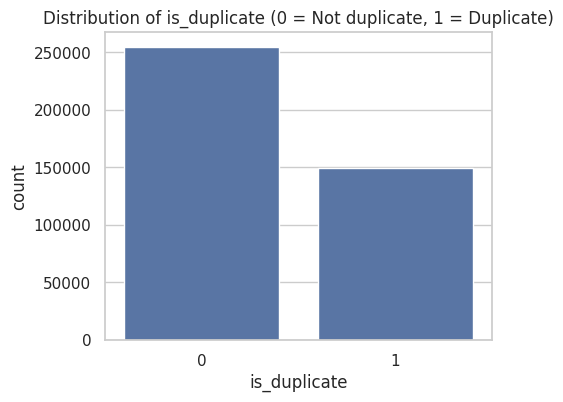


Proportion of duplicates:
is_duplicate
0    0.630752
1    0.369248
Name: proportion, dtype: float64


In [4]:
# Basic info
print("Shape:", df.shape)
print(df.info())

# Missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Distribution of target
plt.figure(figsize=(5,4))
sns.countplot(x='is_duplicate', data=df)
plt.title("Distribution of is_duplicate (0 = Not duplicate, 1 = Duplicate)")
plt.show()

print("\nProportion of duplicates:")
print(df['is_duplicate'].value_counts(normalize=True))


,q1_len,q2_len,q1_char_len,q2_char_len,len_diff
count,404351.000000,404351.000000,404351.000000,404351.000000,404351.000000
mean,10.941771,11.181125,59.533598,60.102883,3.693610
std,5.428721,6.305352,29.939203,33.864489,4.833433
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,7.000000,39.000000,39.000000,1.000000
50%,10.000000,10.000000,52.000000,51.000000,2.000000
75%,13.000000,13.000000,72.000000,72.000000,5.000000
max,125.000000,237.000000,623.000000,1169.000000,223.000000


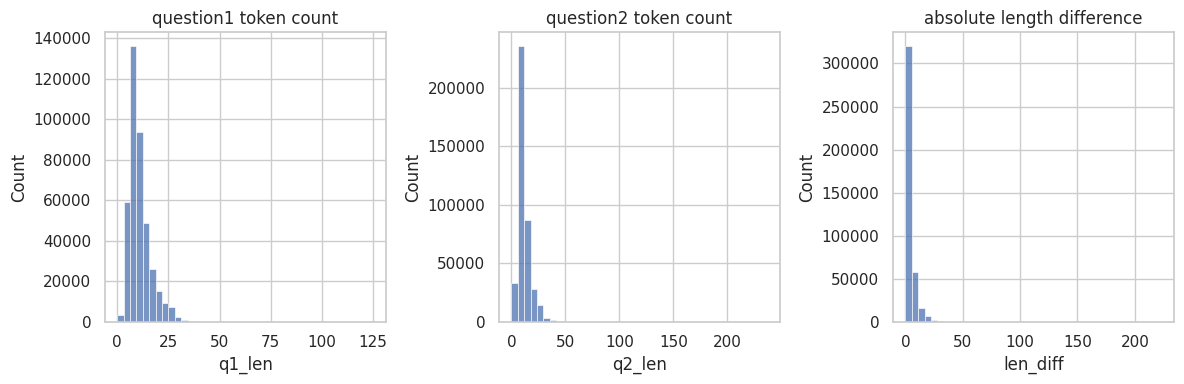

Top words in question1: [('the', 189036), ('what', 163541), ('is', 134345), ('how', 109584), ('i', 105669), ('a', 102151), ('to', 99068), ('in', 98159), ('of', 79969), ('do', 78880), ('are', 73706), ('and', 67155), ('can', 58121), ('for', 51910), ('you', 46474)]
Top words in question2: [('the', 188681), ('what', 161157), ('is', 135651), ('i', 117665), ('how', 111345), ('a', 110060), ('to', 106768), ('in', 99141), ('do', 82236), ('of', 79935), ('are', 72174), ('and', 66833), ('can', 59945), ('for', 52601), ('you', 46675)]


In [5]:
# Create length features
df['q1_len'] = df['question1'].fillna("").apply(lambda x: len(str(x).split()))
df['q2_len'] = df['question2'].fillna("").apply(lambda x: len(str(x).split()))
df['q1_char_len'] = df['question1'].fillna("").apply(lambda x: len(str(x)))
df['q2_char_len'] = df['question2'].fillna("").apply(lambda x: len(str(x)))
df['len_diff'] = (df['q1_len'] - df['q2_len']).abs()

# Show statistics
display(df[['q1_len','q2_len','q1_char_len','q2_char_len','len_diff']].describe())

# Plot distributions
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
sns.histplot(df['q1_len'], bins=40, kde=False).set_title('question1 token count')
plt.subplot(1,3,2)
sns.histplot(df['q2_len'], bins=40, kde=False).set_title('question2 token count')
plt.subplot(1,3,3)
sns.histplot(df['len_diff'], bins=40, kde=False).set_title('absolute length difference')
plt.tight_layout()
plt.show()

# Quick most common words (naive)
def get_top_n_words(series, n=20):
    cnt = Counter()
    for s in series.dropna().astype(str):
        for w in re.findall(r"\w+", s.lower()):
            cnt[w]+=1
    return cnt.most_common(n)

print("Top words in question1:", get_top_n_words(df['question1'], 15))
print("Top words in question2:", get_top_n_words(df['question2'], 15))


In [6]:
def clean_text(text):
    if pd.isnull(text):
        return ""
    text = str(text)
    text = text.lower()
    # replace some contractions or noisy tokens
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"[^a-z0-9\s]", " ", text)  # remove punctuation except alnum and spaces
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Apply cleaning
df['question1_c'] = df['question1'].fillna("").apply(clean_text)
df['question2_c'] = df['question2'].fillna("").apply(clean_text)

# Quick check
df[['question1','question1_c','question2','question2_c']].head(6)


,question1,question1_c,question2,question2_c
0,What is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,what is the story of kohinoor koh i noor diamond,What would happen if the Indian government sto...,what would happen if the indian government sto...
2,How can I increase the speed of my internet co...,how can i increase the speed of my internet co...,How can Internet speed be increased by hacking...,how can internet speed be increased by hacking...
3,Why am I mentally very lonely? How can I solve...,why am i mentally very lonely how can i solve it,Find the remainder when [math]23^{24}[/math] i...,find the remainder when math 23 24 math is div...
4,"Which one dissolve in water quikly sugar, salt...",which one dissolve in water quikly sugar salt ...,Which fish would survive in salt water?,which fish would survive in salt water
5,Astrology: I am a Capricorn Sun Cap moon and c...,astrology i am a capricorn sun cap moon and ca...,"I'm a triple Capricorn (Sun, Moon and ascendan...",i m a triple capricorn sun moon and ascendant ...


In [7]:
# Parameters
MAX_NUM_WORDS = 50000   # vocabulary size
MAX_SEQUENCE_LENGTH = 30  # max tokens per question
EMBEDDING_DIM = 100     # embedding size for Embedding layer

# Fit tokenizer on combined questions
texts = pd.concat([df['question1_c'], df['question2_c']])
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

# Convert to sequences
q1_seq = tokenizer.texts_to_sequences(df['question1_c'])
q2_seq = tokenizer.texts_to_sequences(df['question2_c'])

q1_pad = pad_sequences(q1_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
q2_pad = pad_sequences(q2_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

print("Vocabulary size:", min(MAX_NUM_WORDS, len(tokenizer.word_index)+1))
print("q1_pad shape:", q1_pad.shape, "q2_pad shape:", q2_pad.shape)


Vocabulary size: 50000
q1_pad shape: (404351, 30) q2_pad shape: (404351, 30)


In [8]:
# Target
y = df['is_duplicate'].values

# Split (stratify to preserve class balance)
X = np.stack([q1_pad, q2_pad], axis=1)  # shape (n,2,seq_len)
q1 = q1_pad
q2 = q2_pad

q1_train, q1_val, q2_train, q2_val, y_train, y_val = train_test_split(q1, q2, y, test_size=0.15, random_state=42, stratify=y)

print("Train shape:", q1_train.shape, q2_train.shape, y_train.shape)
print("Val shape:", q1_val.shape, q2_val.shape, y_val.shape)


Train shape: (343698, 30) (343698, 30) (343698,)
Val shape: (60653, 30) (60653, 30) (60653,)


In [9]:
# Build model: shared embedding + BiLSTM -> combine via abs diff and multiply + dense
def build_siamese_model(vocab_size, embedding_dim, seq_len, lstm_units=64, dropout_rate=0.2):
    # Inputs
    inp1 = Input(shape=(seq_len,))
    inp2 = Input(shape=(seq_len,))

    # Shared layers
    emb_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=seq_len, trainable=True, name="embedding")
    shared_lstm = Bidirectional(LSTM(lstm_units, return_sequences=False, dropout=0.2, recurrent_dropout=0.0), name="bilstm")

    # Encode both questions
    e1 = emb_layer(inp1)
    e2 = emb_layer(inp2)

    o1 = shared_lstm(e1)
    o2 = shared_lstm(e2)

    # Feature interactions
    from tensorflow.keras import backend as K
    abs_diff = Lambda(lambda x: K.abs(x[0] - x[1]))([o1, o2])
    mul = Lambda(lambda x: x[0] * x[1])([o1, o2])

    merged = concatenate([abs_diff, mul, o1, o2])
    merged = BatchNormalization()(merged)
    merged = Dense(128, activation='relu')(merged)
    merged = Dropout(dropout_rate)(merged)
    merged = Dense(64, activation='relu')(merged)
    merged = Dropout(dropout_rate)(merged)
    out = Dense(1, activation='sigmoid')(merged)

    model = Model(inputs=[inp1, inp2], outputs=out)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

vocab_size = min(MAX_NUM_WORDS, len(tokenizer.word_index) + 1)
model = build_siamese_model(vocab_size=vocab_size, embedding_dim=EMBEDDING_DIM, seq_len=MAX_SEQUENCE_LENGTH, lstm_units=64)
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 30, 100)   │  5,000,000 │ input_layer[0][0… │
│ (Embedding)         │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm              │ (None, 128)       │     84,480 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128)       │          0 │ bilstm[0][0],     │
│                     │                   │            │ bilstm[1][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 128)       │          0 │ bilstm[0][0],     │
│                     │                   │            │ bilstm[1][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 512)       │          0 │ lambda[0][0],     │
│ (Concatenate)       │                   │            │ lambda_1[0][0],   │
│                     │                   │            │ bilstm[0][0],     │
│                     │                   │            │ bilstm[1][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512)       │      2,048 │ concatenate[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     65,664 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,160,513 (19.69 MB)

 Trainable params: 5,159,489 (19.68 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [11]:
# Callbacks
es = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

rlrp = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

# FIX: Use .keras instead of .h5
checkpoint_path = "best_model.keras"

mc = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1,
    mode='min'
)

# Train
BATCH_SIZE = 1024
EPOCHS = 10

history = model.fit(
    [q1_train, q2_train], y_train,
    validation_data=([q1_val, q2_val], y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[es, rlrp, mc],
    verbose=1
)


Epoch 1/10
335/336 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8273 - loss: 0.3717
Epoch 1: val_loss improved from inf to 0.39199, saving model to best_model.keras
336/336 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.8273 - loss: 0.3717 - val_accuracy: 0.8211 - val_loss: 0.3920 - learning_rate: 0.0010
Epoch 2/10
335/336 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8645 - loss: 0.3030
Epoch 2: val_loss improved from 0.39199 to 0.37971, saving model to best_model.keras
336/336 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.8645 - loss: 0.3031 - val_accuracy: 0.8281 - val_loss: 0.3797 - learning_rate: 0.0010
Epoch 3/10
335/336 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8865 - loss: 0.2579
Epoch 3: val_loss did not improve from 0.37971
336/336 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.8865 - loss: 0.2580 - val_accuracy: 0.8277 - val_loss: 0.4002 - learning_rate: 0.0010
Epoch 4/10
335/336 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9022 - loss: 0.2260
Epoch 4: R

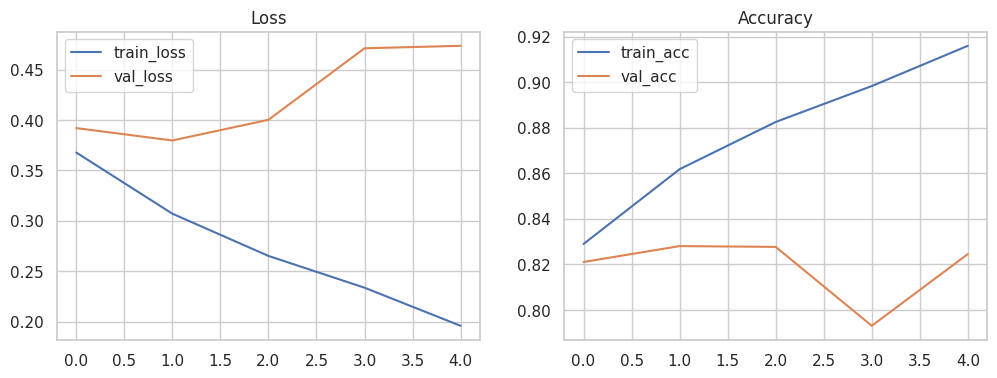

In [12]:
# Plot training/validation loss and accuracy
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title('Accuracy')
plt.show()


In [14]:
# Load best saved model
if os.path.exists(checkpoint_path):
    model.load_weights(checkpoint_path)
    print("Loaded best model weights from", checkpoint_path)

# Predict probabilities and binary predictions
y_val_prob = model.predict([q1_val, q2_val], batch_size=1024)
y_val_pred = (y_val_prob >= 0.5).astype(int)

# Metrics
acc = accuracy_score(y_val, y_val_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_val_pred, average='binary')
roc_auc = roc_auc_score(y_val, y_val_prob)

print(f"Validation Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")

print("\nClassification report:")
print(classification_report(y_val, y_val_pred, digits=4))


Loaded best model weights from best_model.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
Validation Accuracy: 0.8281
Precision: 0.7467, Recall: 0.8087, F1: 0.7765, ROC-AUC: 0.9055

Classification report:
              precision    recall  f1-score   support

           0     0.8823    0.8394    0.8603     38257
           1     0.7467    0.8087    0.7765     22396

    accuracy                         0.8281     60653
   macro avg     0.8145    0.8240    0.8184     60653
weighted avg     0.8322    0.8281    0.8293     60653



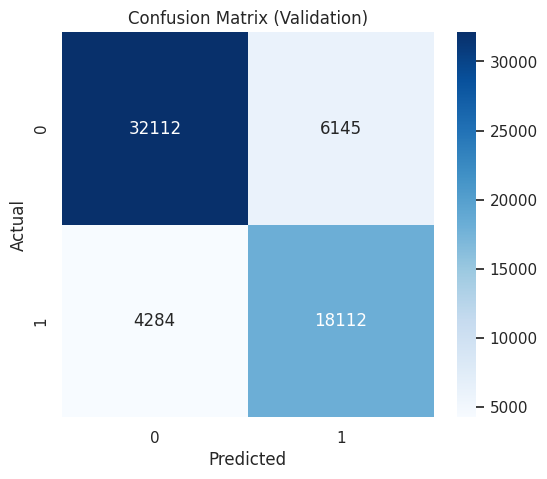

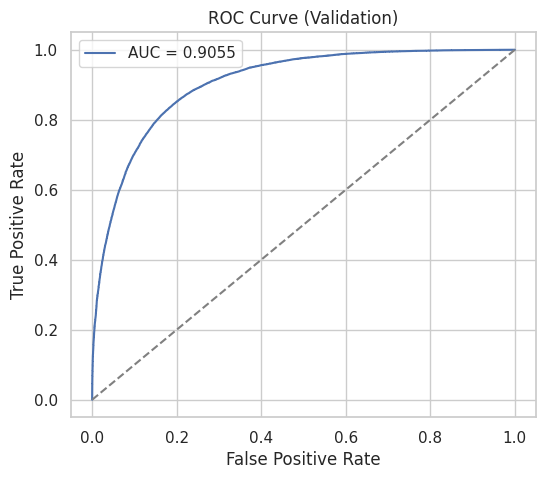

In [17]:
# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Validation)")
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_val, y_val_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Validation)")
plt.legend()
plt.show()


**Performance Evaluation Report**

***Model Used :***

We trained a Siamese LSTM-based neural network for question pair similarity classification.
This architecture helps capture semantic similarity between two text sequences.

***Evaluation Metrics (Validation Set):***

 Accuracy: 0.8281

 Precision (weighted): 0.8322

 Recall (weighted): 0.8281

 F1-score (weighted): 0.8293

 AUC-ROC: 0.9055


***Interpretation***

1. The model achieved a strong balance between precision and recall, indicating good performance in distinguishing duplicate vs non-duplicate questions.

2. A high AUC score suggests that the model generalizes well and separates the two classes effectively.

3. The confusion matrix shows the distribution of errors; false positives and false negatives remain moderate.

4. Further improvements could be done using pretrained language models (BERT/DistilBERT) or hyperparameter tuning.




